In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

In [3]:
import os

%load_ext autoreload
%autoreload 2

os.chdir('/content/drive/MyDrive/PR_202210835/Lab08')

In [4]:
import sample_data
from meanshift import mean_shift
import matplotlib.pyplot as plt

(100, 2)
[[ 9.41309256e+00  3.80126631e+00]
 [-9.72251477e+00  6.01161199e-01]
 [ 1.28294440e+00 -6.13705649e+00]
 [-7.36210444e+00 -7.46120098e-02]
 [-9.53978128e-01 -7.08256146e+00]
 [ 9.08493312e+00  1.12415408e+00]
 [-6.24180450e+00  1.73487169e+00]
 [ 9.64751418e+00  3.23661748e+00]
 [-2.49872427e-01 -7.26371360e+00]
 [ 9.60337561e+00  4.05083377e+00]
 [ 7.68921558e+00  2.37456066e+00]
 [ 1.10601118e+01  5.61542998e+00]
 [ 9.07529629e+00  4.33220215e+00]
 [-6.25343429e+00  2.34014121e+00]
 [-7.45325139e+00 -4.00431927e-01]
 [ 1.09320552e+01  4.45298162e+00]
 [ 8.45384120e-01 -4.56183361e+00]
 [-2.77839499e-01 -6.23554691e+00]
 [ 1.06025886e+01  5.21518542e+00]
 [ 8.97599410e+00  3.54981980e+00]
 [ 9.51249732e+00  1.89380503e+00]
 [ 9.24504941e+00  5.66818056e+00]
 [-2.54635001e-01 -9.49681222e+00]
 [ 8.55856670e+00  3.03174308e+00]
 [-6.57840350e+00  2.00198112e+00]
 [-1.39001965e+00 -5.75601009e+00]
 [ 9.93093341e+00  3.24261512e+00]
 [ 7.09170043e+00  4.59778040e+00]
 [ 9.078235

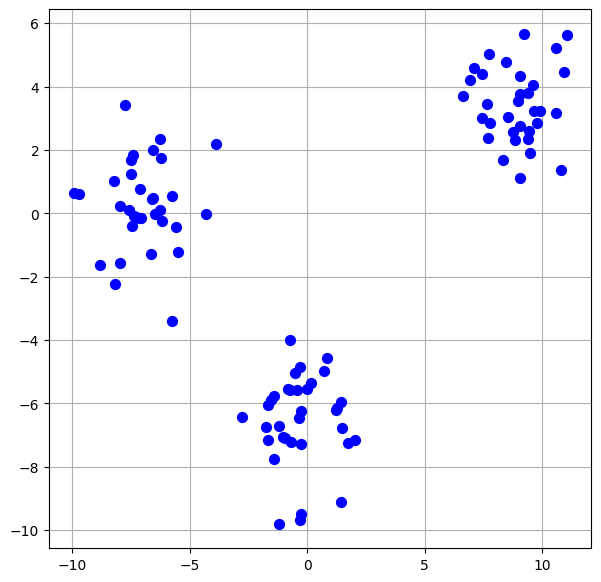

In [ ]:
X = sample_data.sample2

# 데이터 확인
print(X.shape)
print(X)

# 좌표에 그리기
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], color='b', s=50, zorder=2)
plt.grid()
plt.show()

In [ ]:
# meanshift 수행
bandwidth = 4  # 파젠 창, 커널의 폭 h
centroids, history = mean_shift(X, bandwidth)

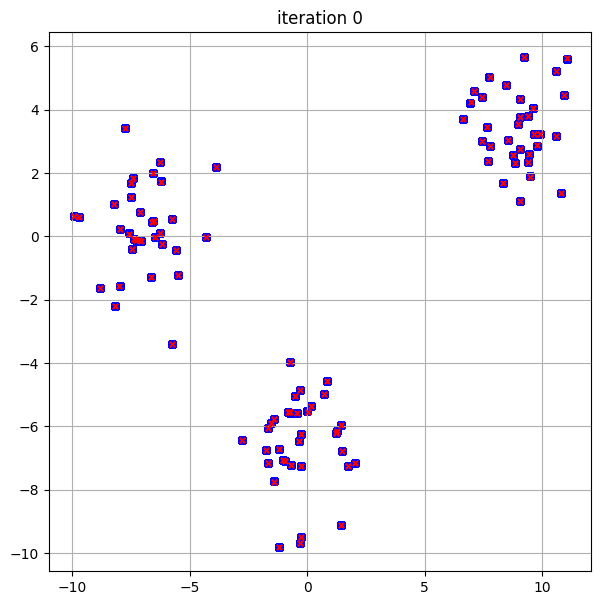

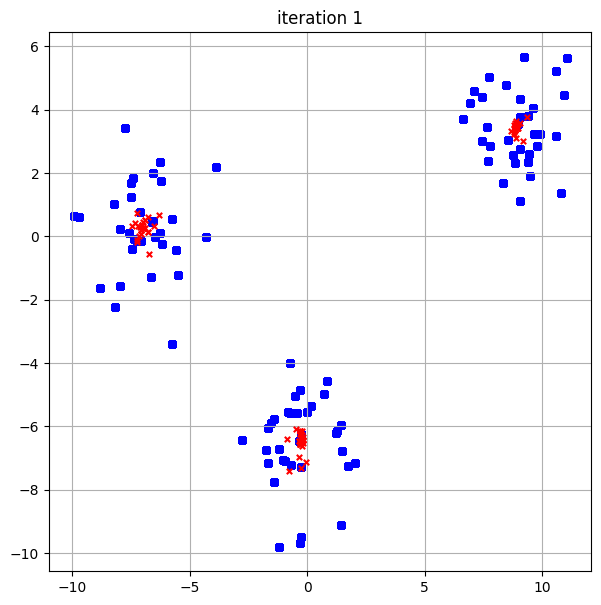

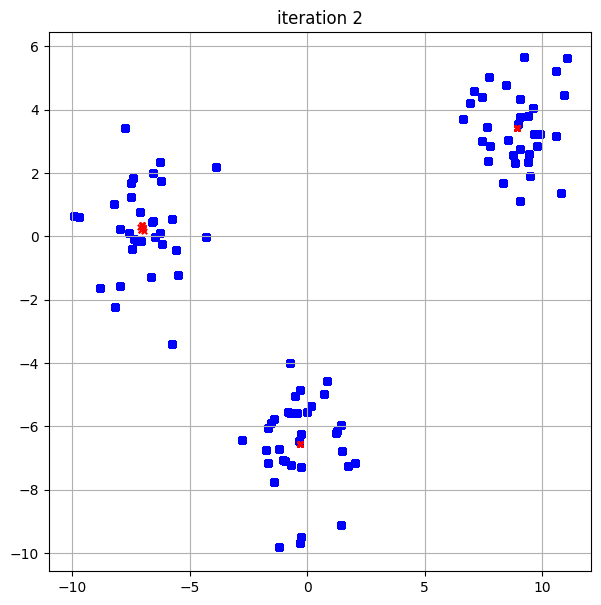

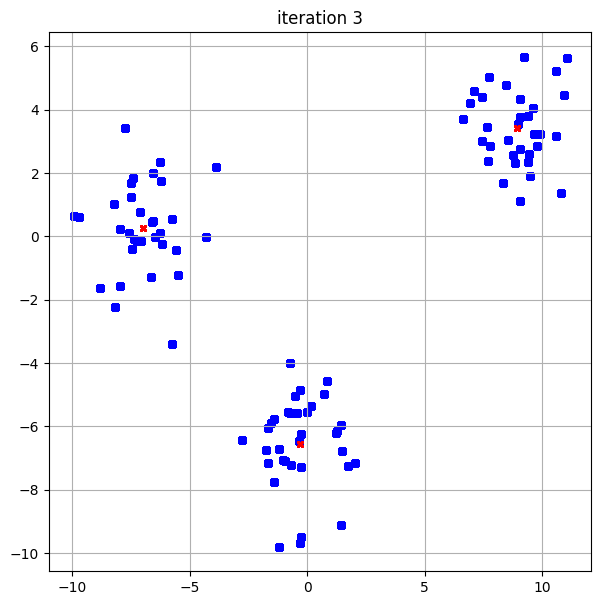

In [ ]:
hist = history
n_iter =max([len(arr) for arr in hist.values()])
for i in range(len(X)):
    n = len(hist[i])

    for j in range(n_iter):
        if j < n:
            hist[i][j] = (round(hist[i][j][0], 2), round(hist[i][j][1], 2))
        else:
            hist[i].append(hist[i][-1])

for i in range(n_iter):
    plt.figure(figsize=(7, 7))

    for j in range(len(X)):
        plt.scatter(X[:,0], X[:,1], color='b', marker='o',  s=30, zorder=1)
        plt.scatter(hist[j][i][0], hist[j][i][1], color='r', marker='x',  s=15, zorder=2)
    plt.title('iteration %d'%i)
    plt.grid()
    plt.show()

# Mean Shift 응용
- Object Tracking


In [5]:
# 비디오 입력 받기
cap = cv2.VideoCapture('lab08_challenge.mp4')
ret, frame = cap.read()

# 추적 하고자 하는 위치 지정함 (x, y, w, h)
out_frame = frame.copy()
p, q, r, s = 400,100, 810, 180
track_window = (r, p, s, q)

# 타겟 영역 정하기
r_o_i = out_frame[p:p + q, r:r + s]

# HSV에서 히스토그램 역투영
hsv = cv2.cvtColor(r_o_i, cv2.COLOR_BGR2HSV)

# H값을 기준으로 히스토그램 생성
roi = cv2.calcHist([hsv], [0], None, [180], [0, 180])
# 정규화
cv2.normalize(roi, roi, 0, 255, cv2.NORM_MINMAX)

# Mean shift 알고리즘 종료 기준
termination = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 15, 2 )

# 출력 저장 'output.avi'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('output.avi', fourcc, 25.0, (1280, 720))

while(True):
  ret, frame = cap.read()
  if not ret:
        break
  out_frame = frame.copy()

	# HSV로 색변환
  hsv = cv2.cvtColor(out_frame, cv2.COLOR_BGR2HSV)
	# 히스토그램 역투영 확률 데이터 얻기
  bp = cv2.calcBackProject([hsv], [0],roi,[0, 180], 1)

	# 역투영 확률값을 Mean shift 인자에 입력
  _, track_window = cv2.meanShift(bp, track_window,termination)

	# Tracking된 영역을 출력 frame에 표시
  x, y, w, h = track_window
  vid = cv2.rectangle(out_frame, (x, y), (x + w, y + h), 255, 2)

	# 출력 영상에 frame 저장
  out.write(vid)

# release cap object
cap.release()
out.release


<function VideoWriter.release>

- Segmentation

Number of segments:  8


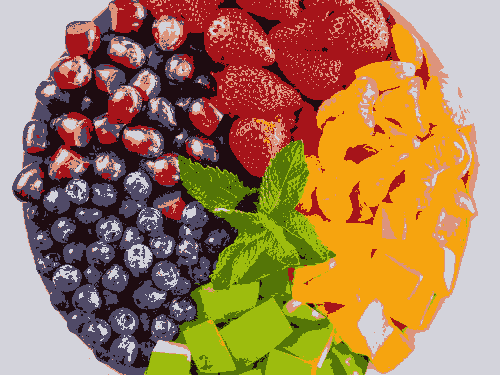

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

img = cv2.imread('lab08_fruit.jpg')

# 블러링을 통한 노이즈 제거
img = cv2.GaussianBlur(img, (5, 5), 0.3)

# flatten the image
flat_image = img.reshape((-1,3))
flat_image = np.float32(flat_image)

# Mean shift
bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
ms.fit(flat_image)
labeled=ms.labels_

# Mean shift를 통해 Clustering 된 중심의 수
segments = np.unique(labeled)
print('Number of segments: ', segments.shape[0])

# 각 Cluster의 중심 색상 저장
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
    total[label] = total[label] + flat_image[i]
    count[label] += 1
avg = total/count
avg = np.uint8(avg)

# 중심 색상으로 변경
res = avg[labeled]
result = res.reshape((img.shape))

# show the result
cv2_imshow(result)